# Predict with pre-trained models

This tutorial explains how to recognize objects in an image with a pre-trained model, and how to perform feature extraction.

## Prerequisites

To complete this tutorial, we need:

- MXNet. See the instructions for your operating system in [Setup and Installation](http://mxnet.io/install/index.html)

- [Matplotlib](https://matplotlib.org/) and [Jupyter Notebook](http://jupyter.org/index.html).

```
$ pip install matplotlib
```

## Loading

We first download a pre-trained ResNet 18 model that is trained on the ImageNet dataset with over 1 million images and one thousand classes. A pre-trained model contains two parts, a json file containing the model definition and a binary file containing the parameters. In addition, there may be a `synset.txt` text file for the labels.

In [16]:
!pip install mxnet

In [17]:
import mxnet as mx
path='http://data.mxnet.io/models/imagenet/'
[mx.test_utils.download(path+'resnet/18-layers/resnet-18-0000.params'),
 mx.test_utils.download(path+'resnet/18-layers/resnet-18-symbol.json'),
 mx.test_utils.download(path+'synset.txt')]

['resnet-18-0000.params', 'resnet-18-symbol.json', 'synset.txt']

Next, we load the downloaded model. 

In [0]:
# set the context on CPU, switch to GPU if there is one available
ctx = mx.cpu()

In [0]:
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-18', 0)
mod = mx.mod.Module(symbol=sym, context=ctx, label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)
with open('synset.txt', 'r') as f:
    labels = [l.rstrip() for l in f]

## Predicting

We first define helper functions for downloading an image and performing the
prediction:

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=False):
    # download and show the image. Remove query string from the file name.
    fname = mx.test_utils.download(url, fname=url.split('/')[-1].split('?')[0])
    img = mx.image.imread(fname)
    if img is None:
        return None
    if show:
        plt.imshow(img.asnumpy())
        plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = mx.image.imresize(img, 224, 224) # resize
    img = img.transpose((2, 0, 1)) # Channel first
    img = img.expand_dims(axis=0) # batchify
    img = img.astype('float32') # for gpu context
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([img]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], labels[i]))

Now, we can perform prediction with any downloadable URL:

probability=0.259132, class=n03188531 diaper, nappy, napkin
probability=0.127626, class=n04235860 sleeping bag
probability=0.051279, class=n03535780 horizontal bar, high bar
probability=0.046732, class=n03888605 parallel bars, bars
probability=0.031626, class=n02777292 balance beam, beam


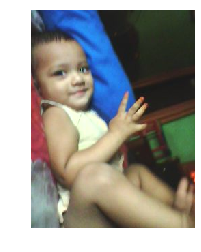

In [21]:
predict('https://github.com/faysalislam/phpto/blob/master/10KB.JPG?raw=true')

probability=0.693706, class=n04285008 sports car, sport car
probability=0.117525, class=n03100240 convertible
probability=0.082952, class=n04037443 racer, race car, racing car
probability=0.047305, class=n02974003 car wheel
probability=0.025246, class=n03459775 grille, radiator grille


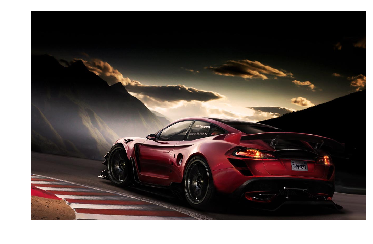

In [22]:
predict('https://github.com/faysalislam/phpto/blob/master/7.jpg?raw=true')

## Feature extraction

By feature extraction, we mean presenting the input images by the output of an internal layer rather than the last softmax layer. These outputs, which can be viewed as the feature of the raw input image, can then be used by other applications such as object detection.

We can use the ``get_internals`` method to get all internal layers from a Symbol.

In [23]:
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['bn1_moving_var',
 'bn1_output',
 'relu1_output',
 'pool1_output',
 'flatten0_output',
 'fc1_weight',
 'fc1_bias',
 'fc1_output',
 'softmax_label',
 'softmax_output']

```
['bn1_moving_var',
 'bn1_output',
 'relu1_output',
 'pool1_output',
 'flatten0_output',
 'fc1_weight',
 'fc1_bias',
 'fc1_output',
 'softmax_label',
 'softmax_output']
 ```

An often used layer for feature extraction is the one before the last fully connected layer. For ResNet, and also Inception, it is the flattened layer with name `flatten0` which reshapes the 4-D convolutional layer output into 2-D for the fully connected layer. The following source code extracts a new Symbol which outputs the flattened layer and creates a model.

In [0]:
fe_sym = all_layers['flatten0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=ctx, label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

We can now invoke `forward` to obtain the features:

In [25]:
img = get_image('https://github.com/dmlc/web-data/blob/master/mxnet/doc/tutorials/python/predict_image/cat.jpg?raw=true')
fe_mod.forward(Batch([img]))
features = fe_mod.get_outputs()[0]
print('Shape',features.shape)
print(features.asnumpy())
assert features.shape == (1, 512)

('Shape', (1L, 512L))
[[1.56397372e-02 3.82902436e-02 7.16170222e-02 1.41408181e+00
  8.97956073e-01 3.83821696e-01 1.50580227e-01 3.32546139e+00
  2.38024426e+00 1.73148438e-01 3.59248668e-01 7.48012602e-01
  1.46563971e+00 9.21020806e-01 1.96286961e-02 3.76605272e-01
  7.35707283e-01 1.83729875e+00 1.29962116e-01 5.12202382e-01
  7.76014686e-01 9.70476419e-02 4.23230529e-02 7.04076961e-02
  3.23318630e-01 3.35603091e-03 2.39051366e+00 9.10300910e-01
  0.00000000e+00 6.61733095e-03 6.93365932e-01 2.19808117e-01
  1.38105154e+00 1.55188255e-02 7.70418525e-01 2.39158273e+00
  1.23402447e-01 6.96272373e-01 5.36274195e-01 1.32665837e+00
  2.12179080e-01 8.09607625e-01 2.24173032e-02 5.29342592e-01
  5.07319272e-01 5.19657254e-01 1.76337790e+00 1.38538033e-01
  7.38721073e-01 8.09316576e-01 7.41666481e-02 3.58267069e+00
  3.80551755e-01 8.10819149e-01 1.17774320e+00 4.26550716e-01
  1.87019557e-01 3.31111662e-02 6.62345409e-01 8.25246572e-01
  1.43625870e-01 1.14618754e+00 5.95506430e-02 8


<!-- INSERT SOURCE DOWNLOAD BUTTONS -->
